In [1]:
import os
import json
import graphviz

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


# dumping the nfa to a file json
def dump_json(nfa, filename):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(nfa, f, ensure_ascii=False, indent=6)


def get_keys_by_group_state(group):
    keys = []
    for state in group:
        for key, value in state.items():
            keys.append(key)

    return keys


In [2]:
import re


class RegexValidator:
    def __init__(self, regex):
        self.regex = regex
        self.postfix = None

    def validate(self):
        try:
            if self.regex.count('[') != self.regex.count(']'):
                print("Invalid regular expression: unmatched brackets")
                return False
            re.compile(self.regex)
        except re.error:
            print("Invalid regex:" , self.regex)
            return False
        return True

    def post_validate(self):
        # we will order regular expressions syntax is listed as in the documentation
        # supported regex syntax
        operators = {"(":0,"|": 1, ".": 2, "?": 3, "+": 4, "*": 5}
        regex = self.regex

        # Check if the regular expression contains any character classes (denoted by square brackets).
        # If a character class is found, the function converts it to an "alternation" #!`() between the characters inside the class`.
        # as example: [xyz] => (x|y|z) and [0-9] will be converted to (0|1|2|3|4|5|6|7|8|9) and so on.

        for i in range(len(regex)):
            operator = regex[i]
            if operator == "[":
                j = i + 1
                while regex[j] != "]":
                    if regex[j].isalnum() and regex[j + 1].isalnum():
                        regex = regex[: j + 1] + "|" + regex[j + 1 :]
                        # print("regex[j + 1:]: ", regex[j + 1:])
                        # print("regex[: j + 1]: ", regex[: j + 1])
                    j += 1

        # then, replace the character class with the new alternation
        regex = regex.replace("[", "(").replace("]", ")")
        print("regex after replacing character classes: ", regex)

        ############################################################
        ############################################################

        # replace hyphen with operator "|" to separate the range of characters in the character class
        # as example: [0-9] will be converted to (0|1|2|3|4|5|6|7|8|9) and so on.
        # as example: [a-z] will be converted to (a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z) and so on.
        self.postfix = regex[:]
        hyphens_count = self.postfix.count("-")
        # print("hyphens_count: ", hyphens_count)
        # print("self.postfix: ", len(self.postfix))
        for i in range(hyphens_count):
            for j in range(len(self.postfix)):
                operator = self.postfix[j]
                # if (a-z) ==> (a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z)
                if operator == "-":
                    temp = ""
                    end = ord(self.postfix[j + 1])
                    start = ord(self.postfix[j - 1])
                    # The line `# print("regex[j - 1]: ", self.postfix[j - 1])` is a commented-out
                    # print statement in the code. It is not currently active and does not affect the
                    # functionality of the code.
                    # print("start: ", start)
                    # print("end: ", end)
                    # print("regex[j]: ", self.postfix)
                    # print("regex[j - 1]: ", self.postfix[j - 1])
                    # print("regex[j + 1]: ", self.postfix[j + 1])
                    for z in range(int(end - start)):
                        temp += "|"
                        char = chr(start + z + 1)
                        temp += char
                    self.postfix = self.postfix[0:j] + temp + self.postfix[j + 2 :]
                    break
        print("regex after replacing hyphens with alternation: ", self.postfix)
        
        # insert . operator between adjacent characters
        dots_container = []
        start_ops = ["*", ")", "+","?"]
        end_ops = ["*", "+",".", ")", "|", "?"]

        for i in range(len(self.postfix) - 1):
            if self.postfix[i].isalnum() and (self.postfix[i + 1].isalnum() or self.postfix[i + 1] == "("):
                dots_container.append(i)
            elif self.postfix[i] in start_ops and self.postfix[i + 1] not in end_ops:
                dots_container.append(i)

        for i in range(len(dots_container)):
            self.postfix = self.postfix[: dots_container[i] + i+ 1] + "." + self.postfix[dots_container[i] +i + 1 :]

        ############################################################
        ############################################################
        print("regex after inserting . operator: ", self.postfix)

        # apply the shunting yard algorithm to convert the infix regular expression to postfix
        stack = []
        postfix = ""
        for i in range(len(self.postfix)):
            operator = self.postfix[i]
            if operator == "(":
                stack.append(operator)
            elif operator == ")":
                while stack[-1] != "(":
                    postfix += stack.pop()
                stack.pop() #! ==> remove the left parenthesis '('
            elif operator in operators:
                while stack and operators[operator] <= operators[stack[-1]]:
                    postfix += stack.pop() 
                stack.append(operator)
            else:
                postfix += operator
            # print("stack: ", stack)
            # print("postfix: ", postfix)
        while stack:
            postfix += stack.pop()

        # print("final postfix: ", postfix)
        # return "a.b?.a.b."
        return postfix


In [3]:
class State:
    def __init__(self, label,  transitions=[], parents=[], is_accepting=True,is_starting=False):
        self.label = label
        self.transitions = []
        self.is_starting = is_starting
        self.is_accepting = is_accepting
        self.parents = parents

    def add_transition(self, symbol, state):
        # if symbol not in self.transitions:
            # self.transitions[symbol] = []
        self.transitions.append((symbol, state))
        state.parents.append(self)
        self.is_accepting = False
 


In [4]:
class NFA:
    def __init__(self, start=None, accept=None, postfix=None):
        self.start = start
        self.accept = accept
        if postfix and not start and not accept:
            self.nfa = self.construct_nfa(postfix)
            self.start = self.nfa.start
            self.accept = self.nfa.accept

    def get_state_by_label(self, label):
        for state in self.get_states():
            if state.label == label:
                return state

    def get_states(self):
        states = []
        visited = set()
        queue = [self.start]
        visited.add(self.start)
        while queue:
            current_state = queue.pop(0)
            # print("state: ", current_state.label)
            # print ("Transitions of current state: ", [state.label for symbol, state in current_state.transitions])
            states.append(current_state)
            # print("Labels of States: ", [state.label for state in states])
            for _,state in current_state.transitions:
                if state not in visited:
                    queue.append(state)
                    visited.add(state)
        
        states.sort(key=lambda x: x.label)
        # print("Final Labels of States: ", [state.label for state in states])
            
        return states

    def get_accepting_states(self):
        return [state for state in self.get_states() if state.is_accepting]
        

    # check if one accpeting state is reachable from another accepting state
    def is_accepting_state_reachable(self,states):
        # print("States in is_accepting_state_reachable: ", states)
        for state in states:
            if state.is_accepting:
                return True
        return False
        
        

    def get_states_by_label(self, labels):
        labels = labels.split()
        states_by_label = []
        for label in labels:
            states_by_label.append(self.get_state_by_label(label))
        return states_by_label

    def get_symbols(self):
        symbols = set()
        states = self.get_states()
        for state in states:
            for symbol, _ in state.transitions:
                if symbol != "ε":
                    symbols.add(symbol)
        # print("Symbols: ", list(symbols))
        return list(symbols)
        
        
        
    def handle_closure(char, nfa_stack, i):
        state_1 = nfa_stack.pop()
        start = State("S" + str(i))
        accept = State("S" + str(i + 1))
        start.add_transition("ε", state_1.start)
        start.add_transition("ε", accept)
        state_1.accept.add_transition("ε", start)
        state_1.accept.add_transition("ε", accept)
        nfa_stack.append(NFA(start, accept))
        return i + 2 
        
    def handle_alternation(char, nfa_stack, i):
        state_2 = nfa_stack.pop()
        state_1 = nfa_stack.pop()
        start = State("S" + str(i))
        accept = State("S" + str(i + 1))
        start.add_transition("ε", state_1.start)
        start.add_transition("ε", state_2.start)
        state_1.accept.add_transition("ε", accept)
        state_2.accept.add_transition("ε", accept)
        nfa_stack.append(NFA(start, accept))
        return i + 2
        
        
    def handle_concatenation(char, nfa_stack, i):
        state_2 = nfa_stack.pop()
        state_1 = nfa_stack.pop()                
        state_1.accept.add_transition("ε", state_2.start)
        nfa_stack.append(NFA(state_1.start, state_2.accept))
        return i 
        
    def handle_positive_closure(char, nfa_stack, i):
        state_1 = nfa_stack.pop()
        start = State("S" + str(i))
        accept = State("S" + str(i + 1))
        start.add_transition("ε", state_1.start)
        state_1.accept.add_transition("ε", start)
        state_1.accept.add_transition("ε", accept)
        nfa_stack.append(NFA(start, accept))
        return i + 2
        
    def handle_optional(char, nfa_stack, i):
        state_1 = nfa_stack.pop()
        start = State("S" + str(i))
        accept = State("S" + str(i + 1))
        start.add_transition("ε", state_1.start)
        start.add_transition("ε", accept)
        state_1.accept.add_transition("ε", accept)
        nfa_stack.append(NFA(start, accept))
        return i + 2
        
    def handle_alpha_numeric(char, nfa_stack, i):
        start = State("S" + str(i))
        accept = State("S" + str(i + 1))
        start.add_transition(char, accept)
        nfa_stack.append(NFA(start, accept))
        return i + 2

    def construct_nfa(self, postfix):
        nfa_stack = []
        i = 1
        for char in postfix:
            if char == "*":
                i = NFA.handle_closure(char, nfa_stack, i)

            elif char == "|":
                i = NFA.handle_alternation(char, nfa_stack, i)
            elif char == ".":
                i = NFA.handle_concatenation(char, nfa_stack, i)
                
            elif char == "+":
                i = NFA.handle_positive_closure(char, nfa_stack, i)
            
            elif char == "?":
                i = NFA.handle_optional(char, nfa_stack, i)
            else:
                i = NFA.handle_alpha_numeric(char, nfa_stack, i)

        return nfa_stack.pop()

    def to_graph(self):

        states = {}
        for state in self.get_states():
            state_graph = {
                "isTerminatingState": state.is_accepting,
            }
            for symbol, transition in state.transitions:
                if symbol not in state_graph:
                    state_graph[symbol] = transition.label
                else:
                    state_graph[symbol] += "," + transition.label
            states[state.label] = state_graph
              
        # make a json object of the NFA graph
        dump_json({"startingState": self.start.label, **states}, "output/nfa/nfa.json")
            
            
        return {
            "startingState": self.start.label,
            **states,
        }

    def visualize(self, name="output/nfa/nfa.gv", view=False,pattern=None):
        nfa_graph = self.to_graph()
        graph = graphviz.Digraph(name="NFA",engine="dot")

        for state, transitions in nfa_graph.items():
            if state == "startingState":
                graph.node("", shape="none")
                graph.edge("", transitions)
                continue
            if transitions["isTerminatingState"]:
                graph.node(state, shape="doublecircle")
            else:
                graph.node(state, shape="circle")
                
                
            for symbol, next_state in transitions.items():
                if symbol == "isTerminatingState":
                    continue
                children = next_state.split(",")
                for child in children:
                    graph.edge(state, child, label=symbol)

        graph.format = "png"
        graph.attr(rankdir="LR",label="NFA's pattern: " + pattern, fontname='bold')
        graph.render(name, view=view)

        return graph


In [5]:
from collections import deque


class DFA:
    def __init__(self, nfa):
        self.nfa = nfa
        self.dfa_states = self.construct_dfa()
        
    def get_symbols(self):
        return self.nfa.get_symbols()
    def get_states(self):
        return self.nfa.get_states()

    def _epsilon_closure(self, states):
        closure = set(states)
        stack = list(states)
        while stack:
            current_state = stack.pop()
            for symbol, next_state in current_state.transitions:
                if symbol == "ε" and next_state not in closure:
                    stack.append(next_state)
                    closure.add(next_state)

        closure = list(closure)
        closure.sort(key=lambda x: x.label)

        closure = " ".join([state.label for state in closure])
        # print("closure: ", closure)
        return closure

    def _move(self, state, symbol):
        next_states = set()

        states = state.split()  
        states_list = []
        for label in states:
            state = self.nfa.get_state_by_label(label)
            # print("State in Move!: ", state.label)
            states_list.append(state)
        for state in states_list:
            for s, next_state in state.transitions:
                if s == symbol:
                    next_states.add(next_state)
        return next_states
    
    def construct_dfa(self):
        dfa_transitions = {}
        symbols = self.nfa.get_symbols()
        dfa_start = self._epsilon_closure([self.nfa.start])
        # print("First Epsilon Closure: ", dfa_start)
        self.dfa_states = {'startingState': dfa_start}

        queue = deque([dfa_start])
        visited = set([dfa_start])

        while queue:
            current_state = queue.popleft()
            # print("current_state: ", current_state)
            for symbol in symbols:
                next_moves = self._move(current_state, symbol)
                if not next_moves:
                    continue
                next_states = self._epsilon_closure(next_moves)
                # print("Current State: ", current_state)
                # print("Symbol: ", symbol)
                # print("Moves: ", [state.label for state in next_moves])
                # print("Epsilon Closures: ", next_states)
                if next_states == " " or next_states == "":
                    continue
                if next_states not in visited:
                    queue.append(next_states)
                    visited.add(next_states)
                self.dfa_states.setdefault(current_state, {})[symbol] = next_states
            states_by_label = self.nfa.get_states_by_label(current_state)
            self.dfa_states.setdefault(current_state, {})["isTerminatingState"] = self.nfa.is_accepting_state_reachable(states_by_label)

        # TODO complete the implementation after Eid break :)

        return self.dfa_states
        

        
    def visualize(self, name="output/dfa/dfa.gv", view=True,pattern=None):
        graph = graphviz.Digraph(name="DFA", engine="dot")
        
        for state, transitions in self.dfa_states.items():
    
            if state == "startingState":
                graph.node("", shape="none")
                graph.edge("", transitions)
                continue
            if transitions["isTerminatingState"]:
                graph.node(state, shape="doublecircle")
            else:
                graph.node(state, shape="circle")
                
                
            for symbol, next_state in transitions.items():
                if symbol == "isTerminatingState":
                    continue
                children = next_state.split(",")
                for child in children:
                    graph.edge(state, child, label=symbol)
                    
        graph.format = "png"
        graph.attr(rankdir="LR",label="DFA's pattern: " + pattern, fontname='bold')
        graph.render(name, view=view)
        


    def to_graph(self):
        dump_json({**self.dfa_states}, "output/dfa/dfa.json")
        return self.dfa_states


In [6]:
class MIN_DFA:
    def __init__(self, dfa):
        self.dfa = dfa
        self.min_dfa_states = self.minimize()
        

    def minimize(self):

        states = self.dfa.to_graph()
        symbols = self.dfa.get_symbols()
        # print("############################################ Min Dfa #########################################")
        # print("Symbols: ", symbols)
        # print("States: ", states)
        # for key in list(states.keys())[1:]:
        #     print(f"{key}: {states[key]}")
        states.pop("startingState")

        #! Step 1: Split the states into two groups
        # Group 1: Accepting states
        # Group 2: Non-accepting states
        group1 = []
        group2 = []
        all_groups = []

        # for key in list(states.keys())[1:]:
        #     if states[key]["isTerminatingState"]:
        #         group1.append(states[key])
        #     else:
        #         group2.append(states[key])
        for key, value in states.items():
            if value["isTerminatingState"]:
                group1.append({key: value})
            else:
                group2.append({key: value})

        all_groups.append(group1)
        all_groups.append(group2)

        # print("Group1: ", group1)
        # print("Group2: ", group2)
        # print("All Groups: ", all_groups)
        #! [[{'S2 S3 S5 S6': {'b': 'S4 S6', 'isTerminatingState': True}}, {'S4 S6': {'isTerminatingState': True}}], [{'S1': {'a': 'S2 S3 S5 S6', 'isTerminatingState': False}}]]

        #! #############    Step 2: Split the groups until no further splits are possible  #############
        #! for each group split the group into subgroups based on the transitions of each state ,
        #! if there is a transition to a state in another group then split the group
        symbol_groups = {}
        i = -1
        length = len(all_groups)
        while i < length:
            i += 1
            if i < 0:
                i = 0
            if i >= len(all_groups):
                break    
            # print("\n")
            # print("\n")
            # print("i ==> ",i)
            # print("length ==> ",length)
            current_group = all_groups[i]
            # print("Current Group: ",current_group)
            
            isSplitted = False
            if len(current_group) < 2:
                continue
            for symbol in symbols:
                if isSplitted:
                    break
                symbol_groups = {}
                for j in range(len(current_group)):
                    current_state = current_group[j]
                    for key, value in current_state.items():
                            if symbol in value:
                                for k in range(len(all_groups)):
                                    for state in all_groups[k]:
                                        if (value[symbol] in state):
                                            # print(symbol,current_state, " is looking in group ",k)
                                            if symbol not in symbol_groups:
                                                symbol_groups[symbol] = {}
                                            if k not in symbol_groups[symbol]:
                                                symbol_groups[symbol][k] = [current_state]
                                            else:
                                                symbol_groups[symbol][k].append(current_state)
                                            # print(symbol_groups)

                            else:
                                # print(symbol,current_state," don't have")
                                k = "none"
                                if symbol not in symbol_groups:
                                    symbol_groups[symbol] = {}
                                if k not in symbol_groups[symbol]:
                                    symbol_groups[symbol][k] = [current_state]
                                else:
                                    symbol_groups[symbol][k].append(current_state)
                                # print(symbol_groups)    
                
                for key, value in symbol_groups.items():
                    # print("Key: ", key, " value: ", value)
                    # Check if the symbol is present in multiple groups
                    if len(value) > 1:
                        all_groups[i] = []
                        isSplitted = True
                        # Extract states associated with each group
                        for group_index, states in value.items():
                            # print("group_index",group_index)
                            # print("states: ",states)
                            all_groups.append(states)
                            # Remove original group from all_groups
                        # Insert the extracted states into all_groups and reset i to 0
                        
                        i = -1
                        break
                # print("All groups: ", all_groups) 
                length = len(all_groups)       
        # Remove empty groups from all_groups            
        all_groups = [group for group in all_groups if group]     



                    
        #! Step 3: Create the minimized DFA
        self.min_dfa_states = self.create_minimized_states(all_groups)

        return self.min_dfa_states

    def create_minimized_states(self, groups):
        # print("########################################################################################")
        # print("\n\n")
        # print("Groups in MIN_DFA: ", groups)
        # print("########################################################################################")
        # print("\n\n")
        #![[{'S2 S3 S5 S6': {'b': 'S4 S6', 'isTerminatingState': True}}], [{'S4 S6': {'isTerminatingState': True}}], [{'S1': {'a': 'S2 S3 S5 S6', 'isTerminatingState': False}}]]
        condensed_states = {}
        # print("Groups in MIN_DFA: ", groups)
        
        for idx, group in enumerate(groups,start=1):
            for state in group:
                # for all states in the group, update the name of the state to the index of the group
                for key, value in state.items():
                    condensed_states[key] = str(idx)
        
        # print("condensed_states: ",condensed_states)
        new_groups = {'startingState': 1}
    
        for idx, group in enumerate(groups,start=1):
            # iterate over each state in the group    
            for state in group:
                # iterate over each symbol in the state
                for key, value in state.items():
                    # iterate over each symbol in the state
                    for symbol, next_state in value.items():
                        if symbol!='isTerminatingState':
                            # print(next_state)
                            # check if the next state is in the condensed states , then update the value of the state
                            if next_state in condensed_states:
                                value[symbol] = str(condensed_states[next_state])
                                new_groups[str(idx)] = value
                                
        for state, group_index in condensed_states.items():
            if group_index not in new_groups:
                new_groups[group_index] = {'isTerminatingState': True}
        # print("New Groups in DFA: ", new_groups)
        #! New Groups in DFA: {'startingState': 1, '1': {'b': '2', 'isTerminatingState': True}, '3': {'a': '1', 'isTerminatingState': False}}            
        return new_groups

    def to_graph(self):
        return self.min_dfa_states

    def visualize(self, name="output/min-dfa/min-dfa.gv", view=True,pattern=None):
        graph = graphviz.Digraph(name="MIN_DFA", engine="dot")
        # print("Minimized DFA States: ", self.min_dfa_states)
        #! Minimized DFA States:  {'startingState': 1, '1': {'b': '2', 'isTerminatingState': True}, '3': {'a': '1', 'isTerminatingState': False}, '2': {'b': '2', 'isTerminatingState': True}}
        for state, transitions in self.min_dfa_states.items():
            if state == "startingState":
                # graph.node("", shape="none")
                # graph.edge("", "1")
                continue
                
            if transitions["isTerminatingState"]:
                graph.node(state, shape="doublecircle")
            else:
                graph.node(state, shape="circle")
            
            
            for symbol, next_state in transitions.items():
                if symbol == "isTerminatingState":
                    continue
                    
                children_states = next_state.split(",")
                for child in children_states:
                    graph.edge(state, child, label=symbol)
                
        graph._format = "png"
        graph.attr(rankdir="LR",label="Min-DFA's pattern: " + pattern, fontname='bold')
        graph.render(name, view=view)
        return graph
        


In [7]:
class RegexProcessor:
    def __init__(self, regex):
        self.regex = regex

    def process(self, idx):
        create_directory("output/nfa")
        create_directory("output/dfa")
        create_directory("output/min-dfa")

        # print(f"\033[1;33m{'#' * 30}\n#     Regex Processor     #\n{'#' * 30}\033[0m\n")
        # print(f"Regex: {self.regex}\n")

        # Validate the regex
        regex_validator = RegexValidator(self.regex)

        if not regex_validator.validate():
            return "Error", None, None

        # Convert the regex to postfix notation
        postfix_regex = regex_validator.post_validate()
        print(f"\033[1;32mPostfix notation: {postfix_regex}\n\033[0m")

        # Convert the regex to an NFA
        nfa = NFA(postfix=postfix_regex)
        print(f"\033[1;36mNFA: {nfa.to_graph()}\n\033[0m")
        nfa.visualize(name=f"output/nfa/nfa_{idx}.gv", view=False,pattern=self.regex)

        # Convert the NFA to a DFA
        dfa = DFA(nfa)
        print(f"\033[1;36mDFA: {dfa.to_graph()}\n\033[0m")
        dfa.visualize(name=f"output/dfa/dfa_{idx}.gv", view=False,pattern=self.regex)

        # Minimize the DFA
        minimized_dfa = MIN_DFA(dfa)
        print(f"\033[1;36mMin-DFA: {minimized_dfa.to_graph()}\n\033[0m")
        minimized_dfa.visualize(name=f"output/min-dfa/min-dfa_{idx}.gv", view=False,pattern=self.regex)

        return "Success", nfa, minimized_dfa


In [8]:

test_cases = [
    # r"ab[ce-df]",
    r"ab"
    r"ab+",
    r"ab*",
    r"ab[ce-df",
    r"ab?ab",
    # r"a[a-z0-1]",
    r"abb+a?(a|b)",
    # r"aab+a*ba?(a|b)",
]

for idx, test_case in enumerate(test_cases, start=1):
    print(f"\033[1;33m{'#' * 30}\n#         TEST CASE {idx}        #\n{'#' * 30}\033[0m\n")

    print("Regex:", test_case)

    processor = RegexProcessor(test_case)
    status, nfa, minimized_dfa = processor.process(idx)

    if status == "Success":
        print("Processing successful!")
    else:
        print("Invalid regex")


##############################
#         TEST CASE 1        #
##############################

Regex: abab+
regex after replacing character classes:  abab+
regex after replacing hyphens with alternation:  abab+
regex after inserting . operator:  a.b.a.b+
Postfix notation: ab.a.b+.

NFA: {'startingState': 'S1', 'S1': {'isTerminatingState': False, 'a': 'S2'}, 'S10': {'isTerminatingState': True}, 'S2': {'isTerminatingState': False, 'ε': 'S3'}, 'S3': {'isTerminatingState': False, 'b': 'S4'}, 'S4': {'isTerminatingState': False, 'ε': 'S5'}, 'S5': {'isTerminatingState': False, 'a': 'S6'}, 'S6': {'isTerminatingState': False, 'ε': 'S9'}, 'S7': {'isTerminatingState': False, 'b': 'S8'}, 'S8': {'isTerminatingState': False, 'ε': 'S9,S10'}, 'S9': {'isTerminatingState': False, 'ε': 'S7'}}

DFA: {'startingState': 'S1', 'S1': {'a': 'S2 S3', 'isTerminatingState': False}, 'S2 S3': {'b': 'S4 S5', 'isTerminatingState': False}, 'S4 S5': {'a': 'S6 S7 S9', 'isTerminatingState': False}, 'S6 S7 S9': {'b': 'S10 S

##############################
              NFA         
##############################

Regex: abab+


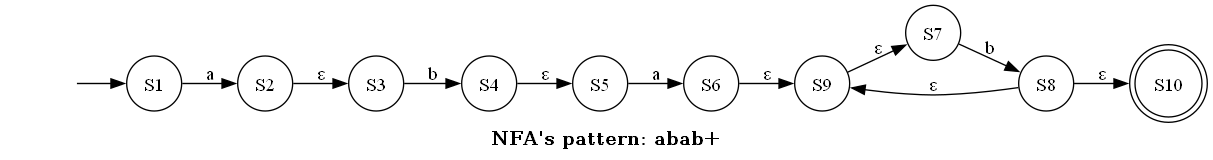

Regex: ab*


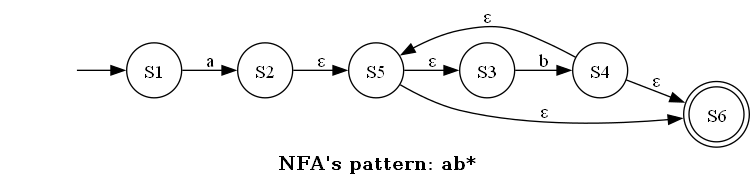

Regex: ab[ce-df
No image found for nfa 3
Regex: ab?ab


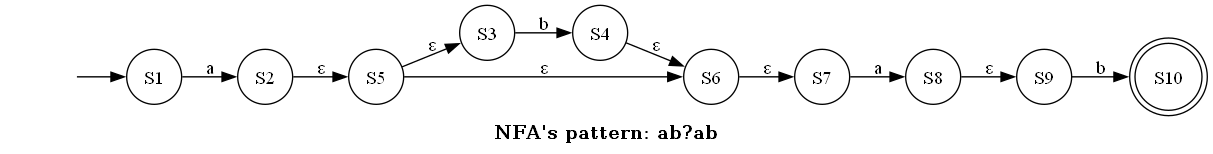

Regex: abb+a?(a|b)


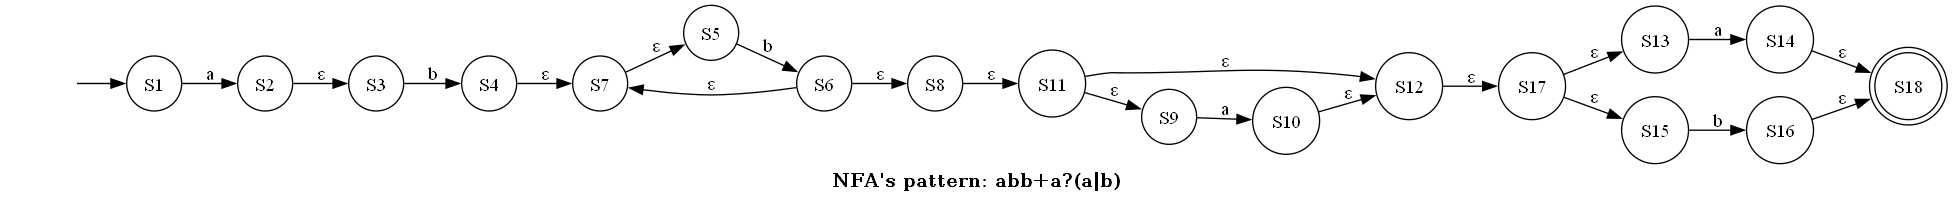

##############################
              DFA         
##############################

Regex: abab+


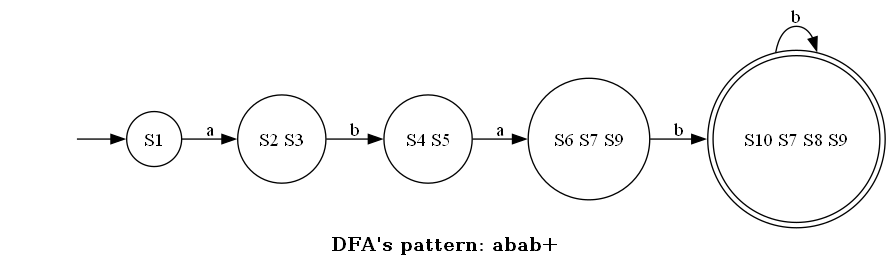

Regex: ab*


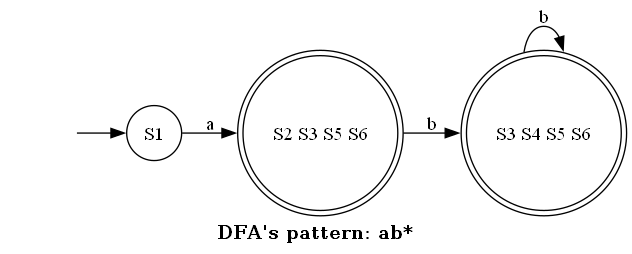

Regex: ab[ce-df
No image found for dfa 3
Regex: ab?ab


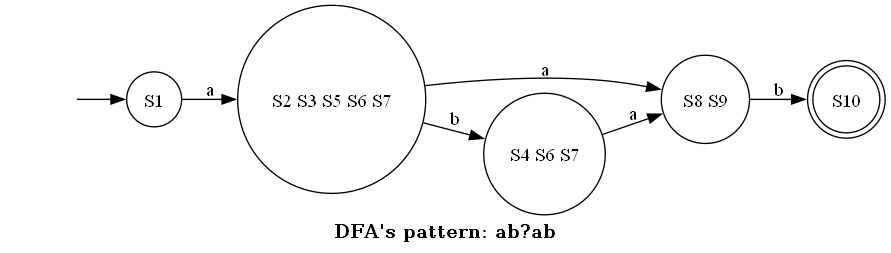

Regex: abb+a?(a|b)


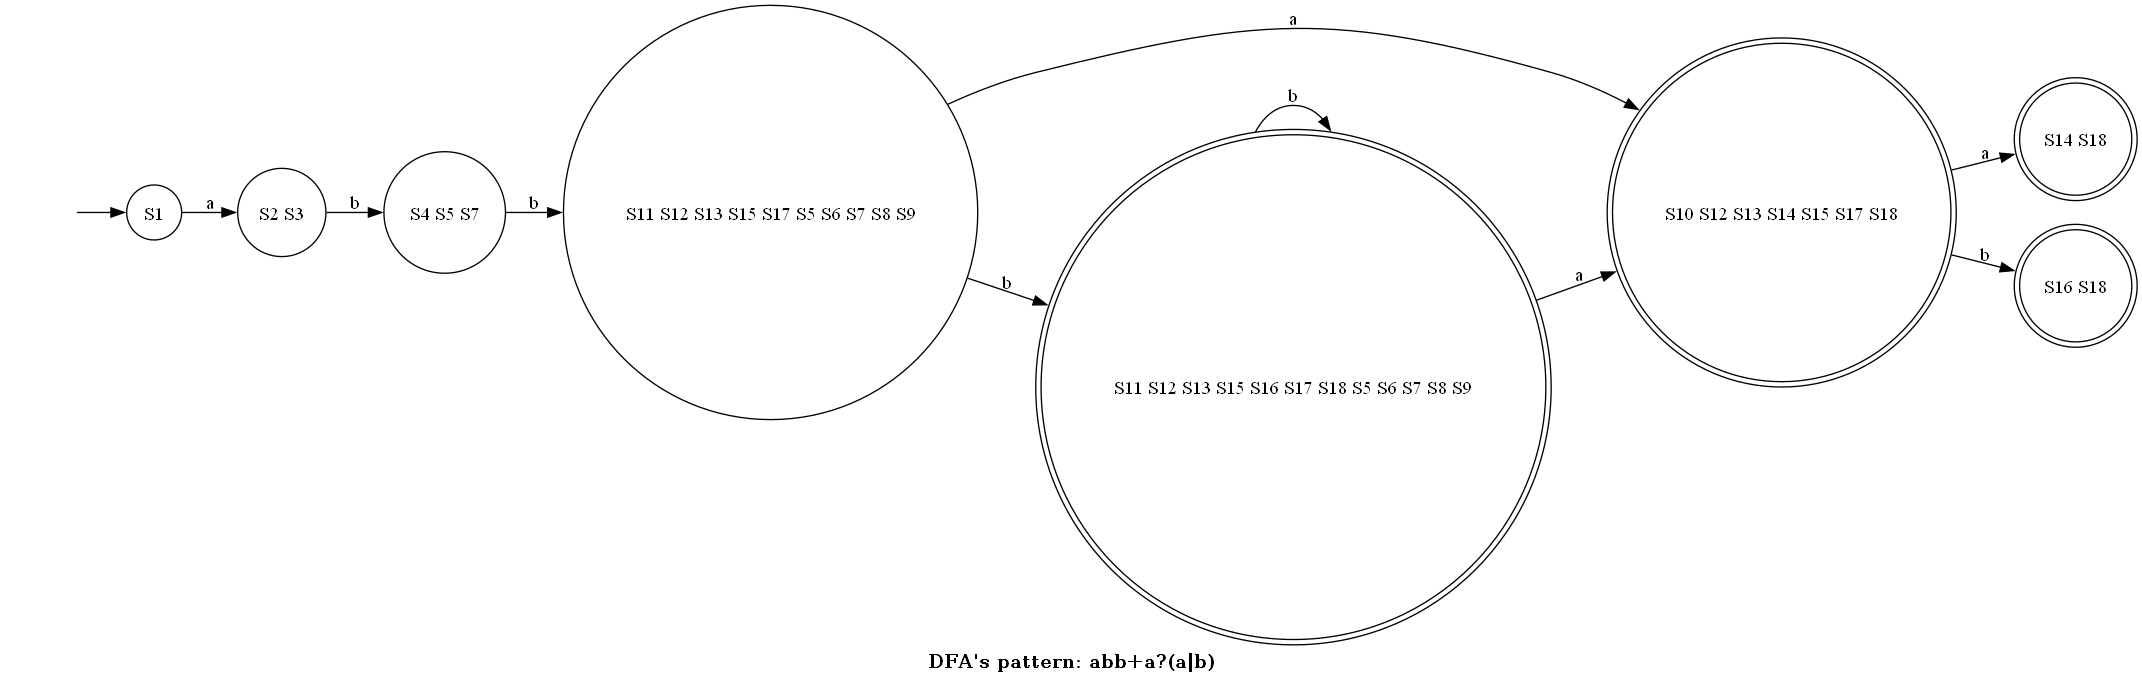

##############################
              MIN-DFA         
##############################

Regex: abab+


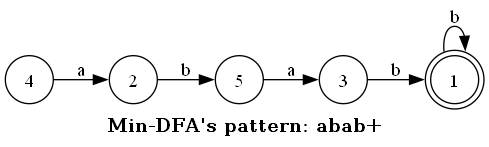

Regex: ab*


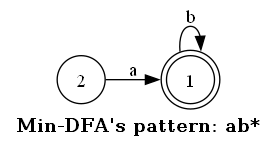

Regex: ab[ce-df
No image found for min-dfa 3
Regex: ab?ab


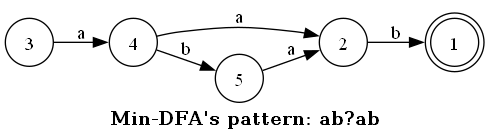

Regex: abb+a?(a|b)


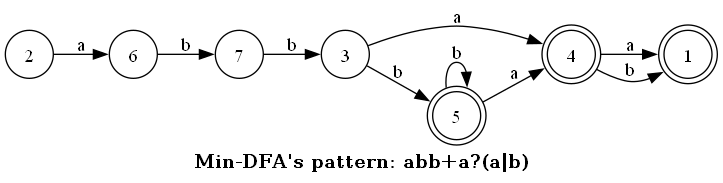

In [17]:
import os
from IPython.display import Image


folders = ["nfa", "dfa", "min-dfa"]


for idx,folder in enumerate(folders, start=1):
    print(f"\033[1;33m{'#' * 30}\n              {folder.upper()}         \n{'#' * 30}\033[0m\n")
    
    
    for idx,test_case in enumerate(test_cases, start=1):
        print("Regex:", test_case)
    
        image_path = f"output/{folder}/{folder}_{idx}.gv.png"
        if os.path.exists(image_path):
            display(Image(image_path))
        else:
            print(f"No image found for {folder} {idx}")
